In [ ]:
!pip install transformers
!pip install torch
!pip install --upgrade datasets
!pip install tqdm
!pip install rouge

from sklearn.metrics.pairwise import cosine_similarity
from datasets import Dataset, DatasetDict, load_dataset
from huggingface_hub import login
from transformers import AutoModelForCausalLM, AutoTokenizer, BertTokenizer, BertModel, AutoTokenizer, AutoModel
from tqdm import tqdm
from sklearn.metrics import cohen_kappa_score
from rouge import Rouge

import json
import pandas as pd
import matplotlib.pyplot as plt
import statistics
import numpy as np
import random
import torch
import re
import transformers
import seaborn as sns

login(token="xxx")
base = '-self'

DATASET LOADING

In [ ]:
dataset_gemma = load_dataset("Ramitha/newsqa-results-40-gemma" + base)
df_gemma = pd.DataFrame(dataset_gemma['rawcases'])
dataset_llama = load_dataset("Ramitha/newsqa-results-40-llama" + base)
df_llama = pd.DataFrame(dataset_llama['rawcases'])
dataset_falcon = load_dataset("Ramitha/newsqa-results-40-falcon" + base)
df_falcon = pd.DataFrame(dataset_falcon['rawcases'])
dataset_mistral = load_dataset("Ramitha/newsqa-results-40-mistral" + base)
df_mistral = pd.DataFrame(dataset_mistral['rawcases'])

In [3]:
gold_standard_cos_dict = {"gemma": df_gemma["gold_standard_cos"].mean(),
                                "llama": df_llama["gold_standard_cos"].mean(),
                                "falcon": df_falcon["gold_standard_cos"].mean(),
                                "mistral": df_mistral["gold_standard_cos"].mean()}
cosine_score_mean_dict = {"gemma": df_gemma["ILRSim"].mean(),
                                "llama": df_llama["ILRSim"].mean(),
                                "falcon": df_falcon["ILRSim"].mean(),
                                "mistral": df_mistral["ILRSim"].mean()}
iaa_dict = {"gemma": df_gemma["iaa_fleiss_kappa"].mean(),
                                "llama": df_llama["iaa_fleiss_kappa"].mean(),
                                "falcon": df_falcon["iaa_fleiss_kappa"].mean(),
                                "mistral": df_mistral["iaa_fleiss_kappa"].mean()}
iaa_agreement_dict = {"gemma": df_gemma["iaa_fleiss_kappa_agreement"].mean(),
                                "llama": df_llama["iaa_fleiss_kappa_agreement"].mean(),
                                "falcon": df_falcon["iaa_fleiss_kappa_agreement"].mean(),
                                "mistral": df_mistral["iaa_fleiss_kappa_agreement"].mean()}
reconstruction_error_mean_dict = {"gemma": df_gemma["ILRError"].mean(),
                                "llama": df_llama["ILRError"].mean(),
                                "falcon": df_falcon["ILRError"].mean(),
                                "mistral": df_mistral["ILRError"].mean()}
case_alignment_dict = {"gemma": df_gemma["ILRAlign"].mean(),
                                "llama": df_llama["ILRAlign"].mean(),
                                "falcon": df_falcon["ILRAlign"].mean(),
                                "mistral": df_mistral["ILRAlign"].mean()}
question_bm25_score_mean_dict = {"gemma": df_gemma["question_bm25_score_mean"].mean(),
                                "llama": df_llama["question_bm25_score_mean"].mean(),
                                "falcon": df_falcon["question_bm25_score_mean"].mean(),
                                "mistral": df_mistral["question_bm25_score_mean"].mean()}
question_rouge_score_mean_dict = {"gemma": df_gemma["question_rouge_score_mean"].mean(),
                                "llama": df_llama["question_rouge_score_mean"].mean(),
                                "falcon": df_falcon["question_rouge_score_mean"].mean(),
                                "mistral": df_mistral["question_rouge_score_mean"].mean()}
question_bleu_score_mean_dict = {"gemma": df_gemma["question_bleu_score_mean"].mean(),
                                "llama": df_llama["question_bleu_score_mean"].mean(),
                                "falcon": df_falcon["question_bleu_score_mean"].mean(),
                                "mistral": df_mistral["question_bleu_score_mean"].mean()}

In [4]:
def get_key_temperatures(grouped_data):
    sorted_data = grouped_data.sort_values(by='gold_standard_cos')
    lowest_temp = sorted_data.idxmin()['gold_standard_cos']
    lowest_value = sorted_data.min()['gold_standard_cos']
    highest_temp = sorted_data.idxmax()['gold_standard_cos']
    highest_value = sorted_data.max()['gold_standard_cos']
    avg_value = sorted_data['gold_standard_cos'].mean()
    avg_temp = (sorted_data['gold_standard_cos'] - avg_value).abs().idxmin()
    return lowest_temp, avg_temp, highest_temp

GEMMA AS A MODEL

Sample count 400


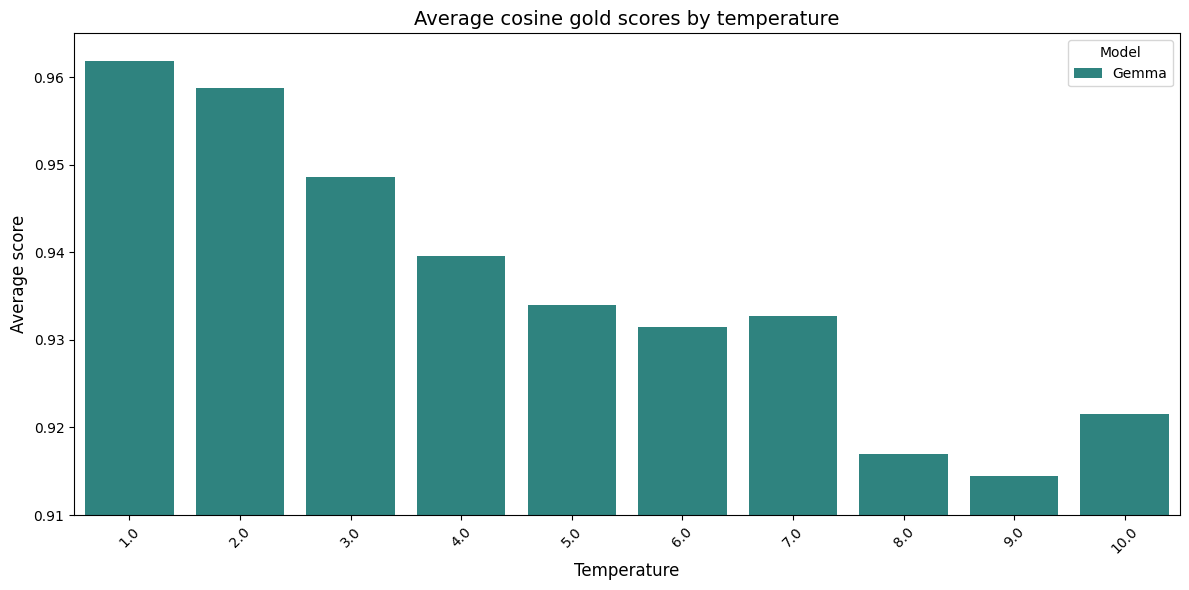

In [5]:
start_index = 0
end_index = 400
print('Sample count', end_index - start_index)
df_gemma = df_gemma[start_index: end_index]
grouped_gemma = df_gemma.groupby('temperature')[['gold_standard_cos']].mean()
grouped_gemma['Model'] = 'Gemma'
all_grouped_scores = pd.concat(
    [
        grouped_gemma
    ]
)
all_grouped_scores = all_grouped_scores.reset_index()
melted_scores = all_grouped_scores.melt(
    id_vars=['temperature', 'Model'],
    var_name='Metric',
    value_name='Average'
)
plt.figure(figsize=(12, 6))
sns.barplot(
    x='temperature',
    y='Average',
    hue='Model',
    data=melted_scores,
    palette='viridis'
)
plt.title('Average cosine gold scores by temperature', fontsize=14)
plt.ylabel('Average score', fontsize=12)
plt.ylim(0.91, 0.965)
plt.xlabel('Temperature', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='Model')
plt.tight_layout()
plt.show()

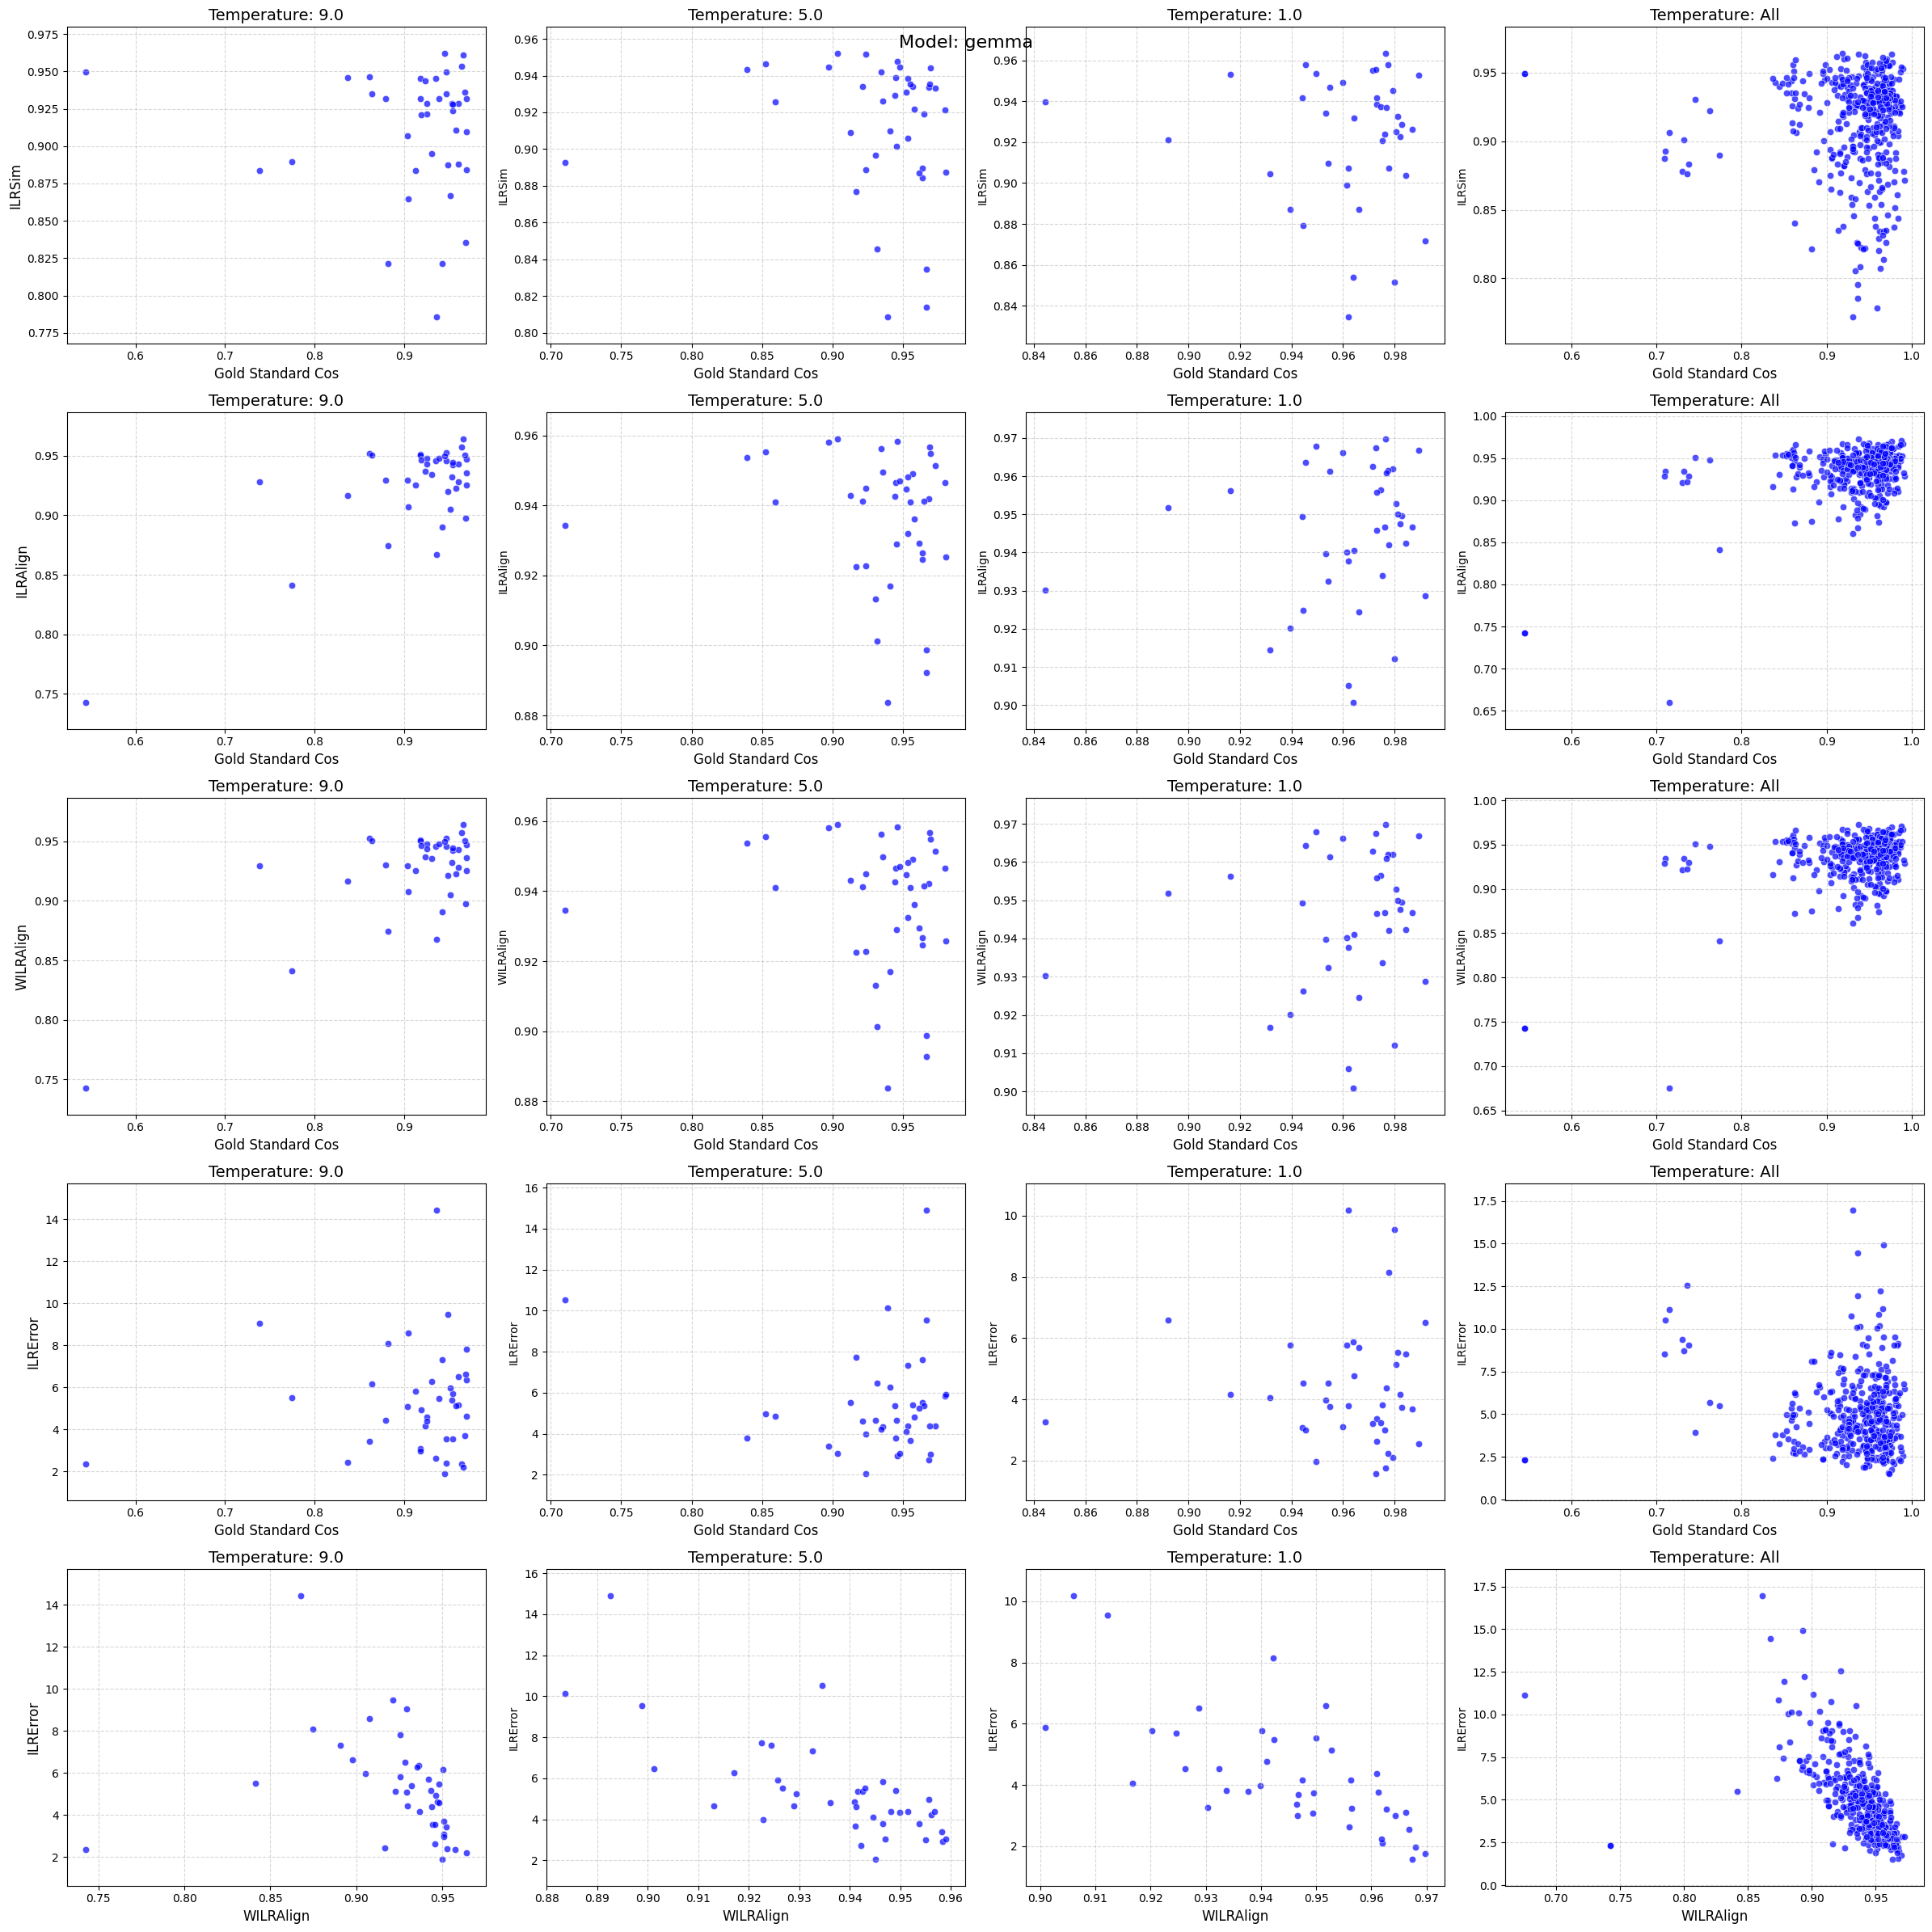

In [6]:
gemma_values = get_key_temperatures(grouped_gemma)
gemma_temperature_selection = [gemma_values[0], gemma_values[1], gemma_values[2]]
temperature_selections = {
    'gemma': (gemma_temperature_selection, df_gemma)
}

max_temps = max(len(temp_selection) for temp_selection, _ in temperature_selections.values()) + 1

for model, (temp_selection, df) in temperature_selections.items():
    fig, axes = plt.subplots(5, max(len(temp_selection) + 1, max_temps),
                              figsize=((max_temps) * 6, 4 * 6),
                              sharey=False)

    def get_dynamic_limits(data, y_column):
        min_val, max_val = data[y_column].min(), data[y_column].max()
        margin = (max_val - min_val) * 0.1
        return min_val - margin, max_val + margin

    for row, y_column, y_label in zip(
        range(6),
        ['ILRSim', 'ILRAlign', 'WILRAlign', 'ILRError', 'ILRError'],
        ['ILRSim', 'ILRAlign', 'WILRAlign', 'ILRError', 'ILRError']
    ):
        for col, temp in enumerate(temp_selection + ['All']):
            ax = axes[row, col] if len(temp_selection) > 1 else axes[row]
            filtered_df = df if temp == 'All' else df[df['temperature'] == temp]
            sns.scatterplot(
                x='gold_standard_cos' if row < 4 else 'WILRAlign',
                y=y_column,
                data=filtered_df,
                ax=ax,
                color='blue',
                alpha=0.7
            )
            y_min, y_max = get_dynamic_limits(filtered_df, y_column)
            ax.set_ylim(y_min, y_max)
            ax.set_title(f'Temperature: {temp}', fontsize=14)
            ax.set_xlabel('Gold Standard Cos' if row < 4 else 'WILRAlign', fontsize=12)
            if col == 0:
                ax.set_ylabel(y_label, fontsize=12)
            ax.grid(True, linestyle='--', alpha=0.5)

    for row in range(4):
        for col in range(len(temp_selection) + 1, max_temps):
            fig.delaxes(axes[row, col] if len(temp_selection) > 1 else axes[row])

    plt.tight_layout()
    plt.suptitle(f'Model: {model}', fontsize=16)
    plt.show()


In [7]:
for model, (temp_selection, df) in temperature_selections.items():
    print(f'Pearson Correlation Coefficients for Model: {model} \n')

    correlation_types = {
        'Gold Standard Cos vs ILRSim': ('gold_standard_cos', 'ILRSim'),
        'Gold Standard Cos vs ILRAlign': ('gold_standard_cos', 'ILRAlign'),
        'Gold Standard Cos vs WILRAlign': ('gold_standard_cos', 'WILRAlign'),
        'Gold Standard Cos vs ILRError': ('gold_standard_cos', 'ILRError')
    }

    for key, (col1, col2) in correlation_types.items():
        print(f'--- {key} ---')
        for temp in temp_selection + ['All']:
            filtered_df = df if temp == 'All' else df[df['temperature'] == temp]
            correlation = filtered_df[col1].corr(filtered_df[col2])
            print(f'Temperature {temp}: {correlation:.4f}')
        print()

Pearson Correlation Coefficients for Model: gemma 

--- Gold Standard Cos vs ILRSim ---
Temperature 9.0: -0.0692
Temperature 5.0: -0.0941
Temperature 1.0: -0.0645
Temperature All: -0.0290

--- Gold Standard Cos vs ILRAlign ---
Temperature 9.0: 0.7204
Temperature 5.0: -0.1328
Temperature 1.0: 0.1656
Temperature All: 0.4308

--- Gold Standard Cos vs WILRAlign ---
Temperature 9.0: 0.7194
Temperature 5.0: -0.1333
Temperature 1.0: 0.1623
Temperature All: 0.4310

--- Gold Standard Cos vs ILRError ---
Temperature 9.0: 0.0680
Temperature 5.0: -0.1214
Temperature 1.0: 0.0119
Temperature All: -0.0918



LLAMA AS A MODEL


Sample count 400


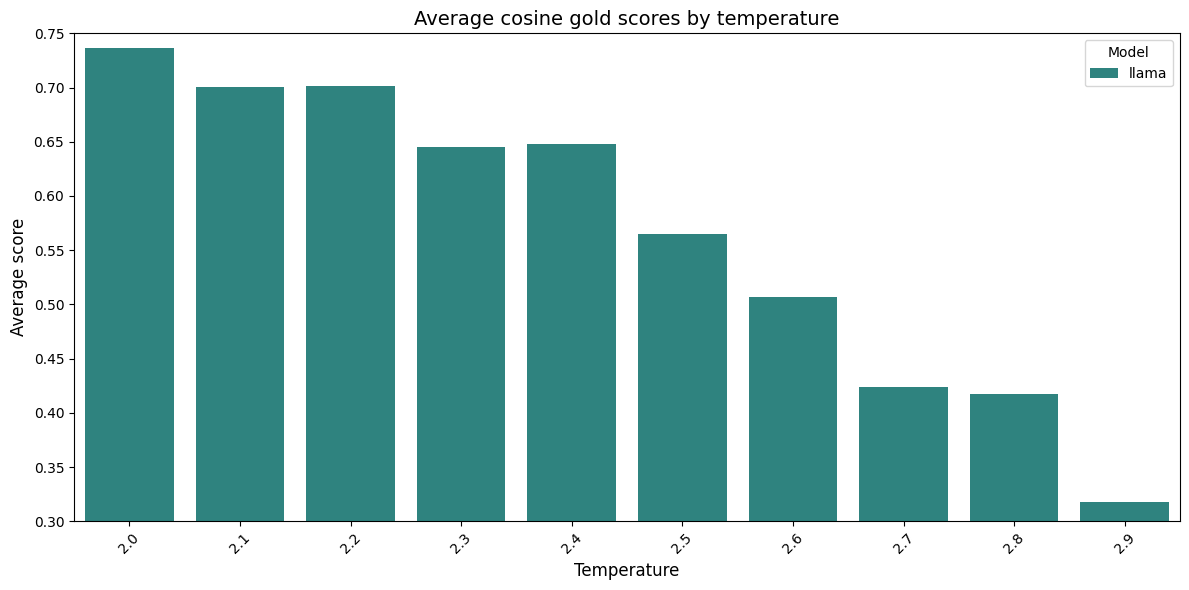

In [8]:
start_index = 0
end_index = 400
print('Sample count', end_index - start_index)
df_llama = df_llama[start_index: end_index]
grouped_llama = df_llama.groupby('temperature')[['gold_standard_cos']].mean()
grouped_llama['Model'] = 'llama'
all_grouped_scores = pd.concat(
    [
        grouped_llama
    ]
)
all_grouped_scores = all_grouped_scores.reset_index()
melted_scores = all_grouped_scores.melt(
    id_vars=['temperature', 'Model'],
    var_name='Metric',
    value_name='Average'
)
plt.figure(figsize=(12, 6))
sns.barplot(
    x='temperature',
    y='Average',
    hue='Model',
    data=melted_scores,
    palette='viridis'
)
plt.title('Average cosine gold scores by temperature', fontsize=14)
plt.ylabel('Average score', fontsize=12)
plt.ylim(0.3, 0.75)
plt.xlabel('Temperature', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='Model')
plt.tight_layout()
plt.show()

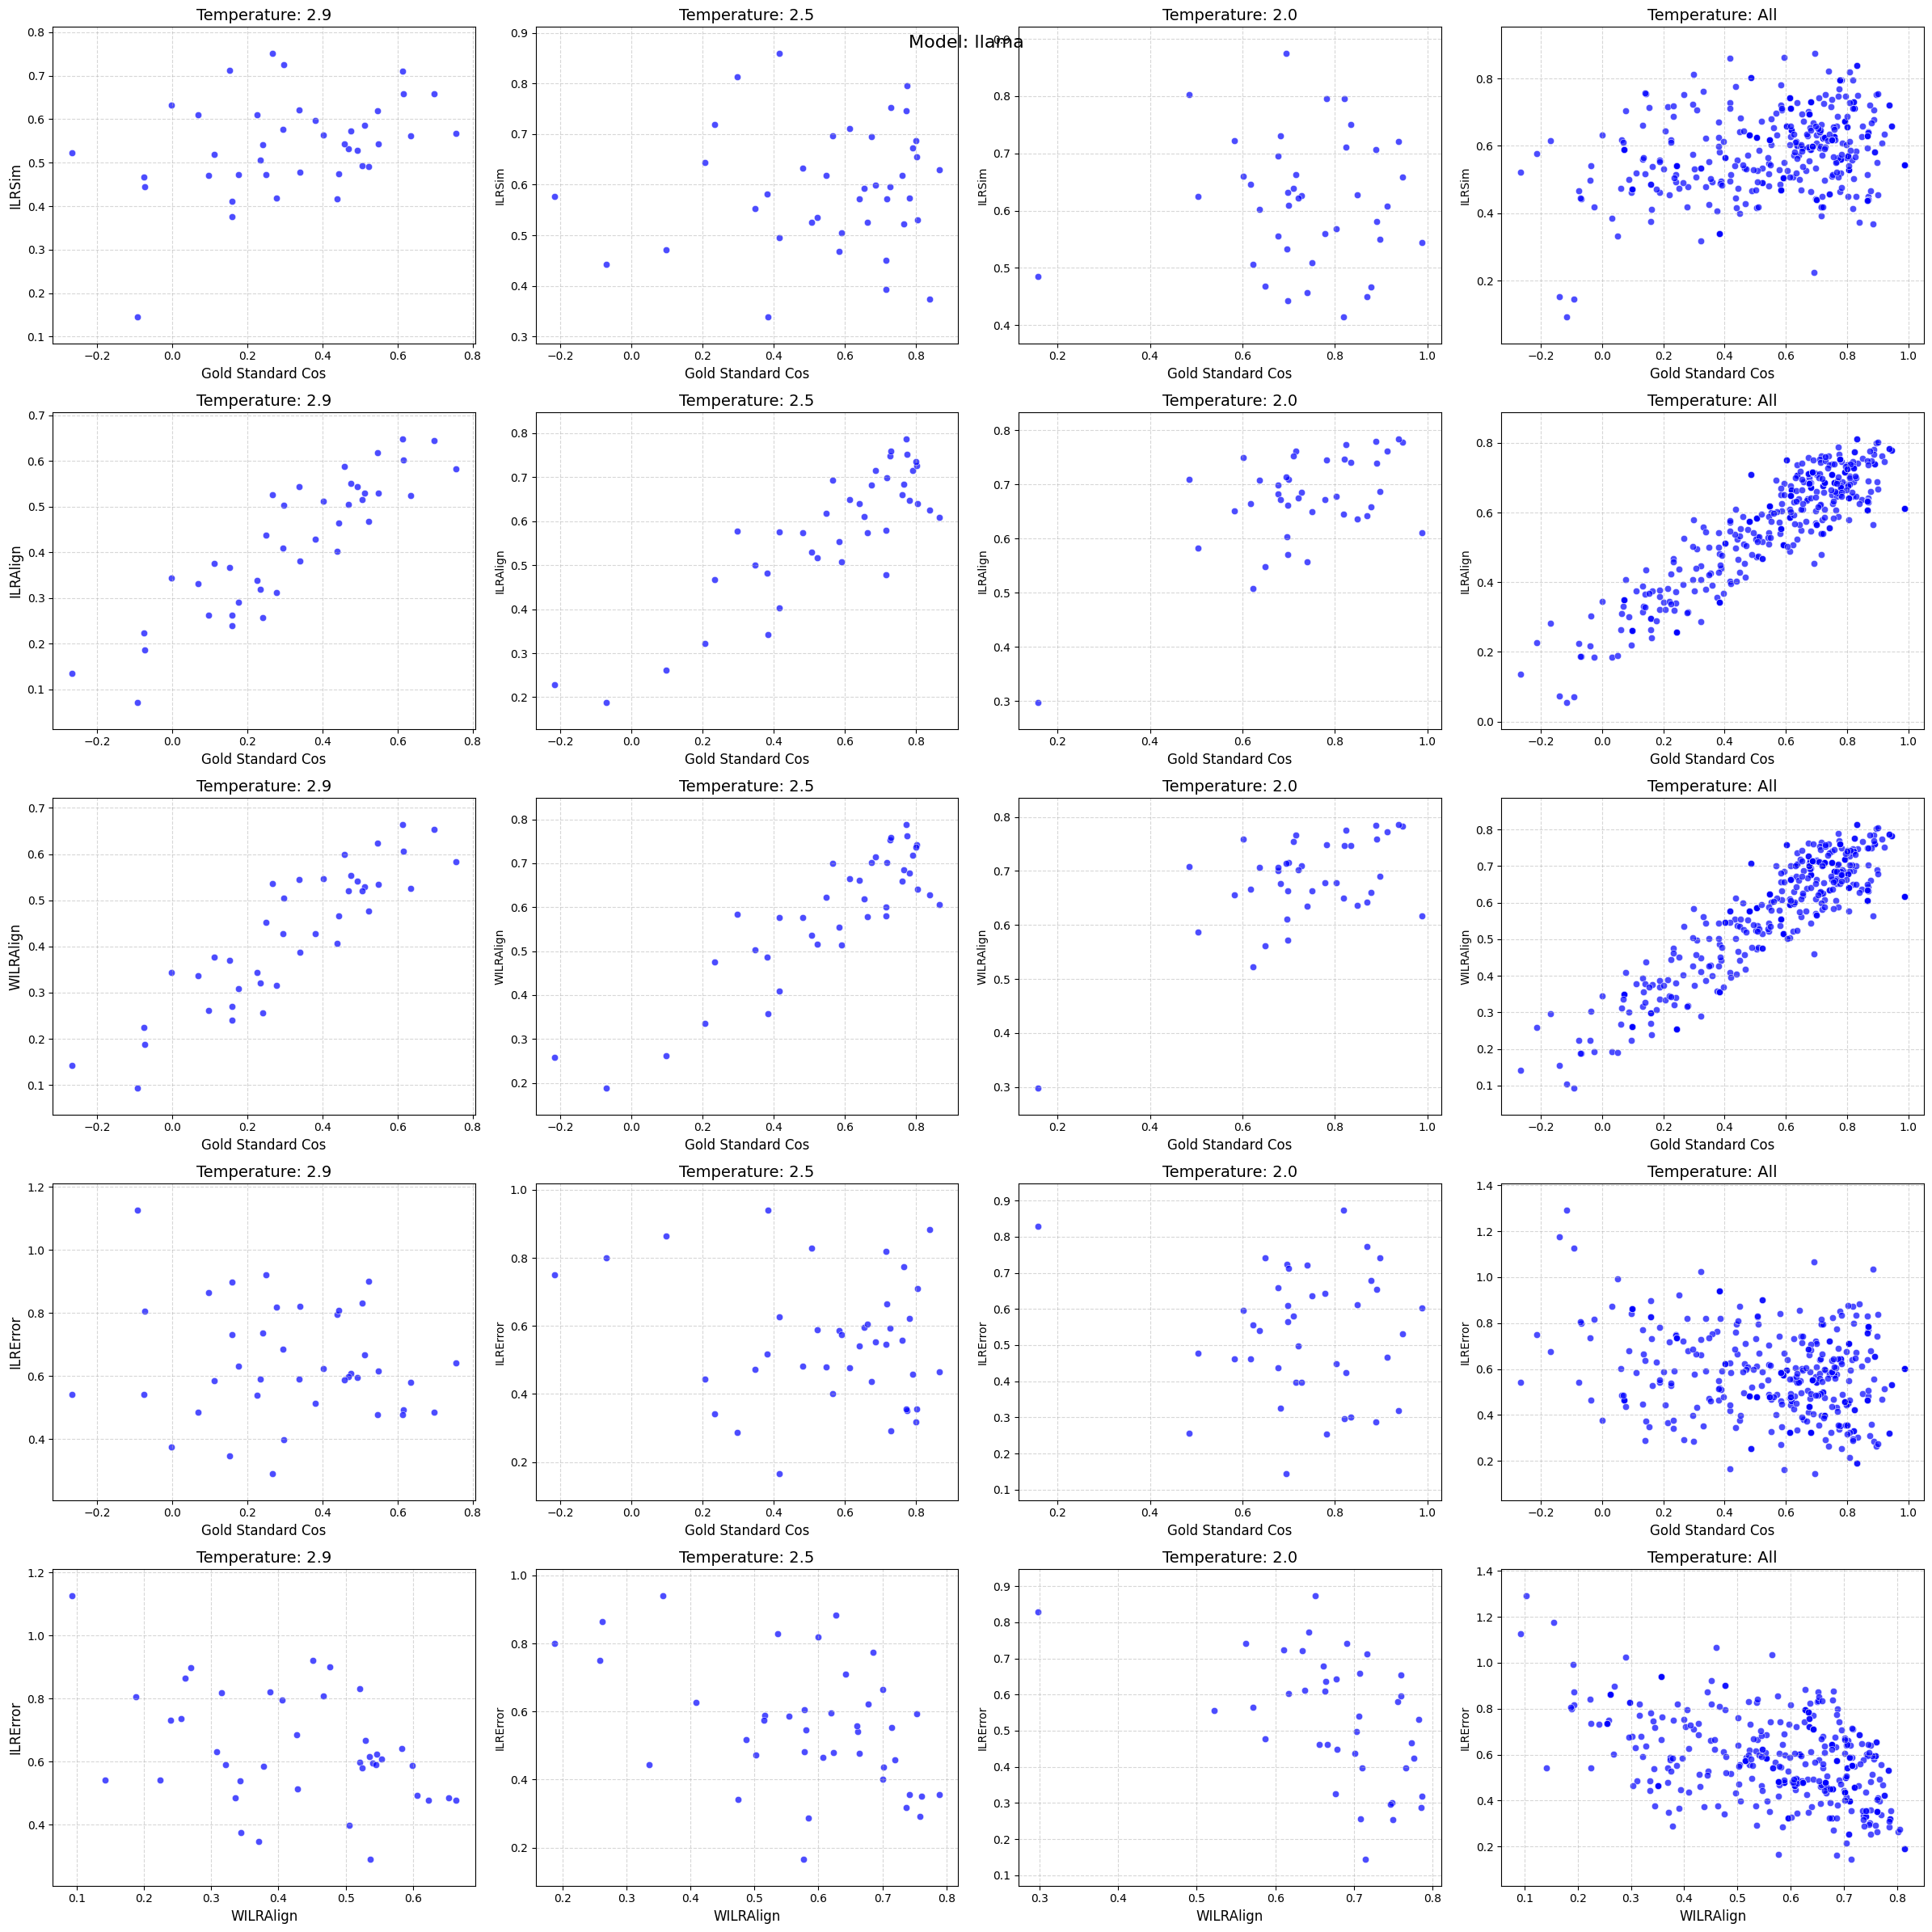

In [9]:
llama_values = get_key_temperatures(grouped_llama)
llama_temperature_selection = [llama_values[0], llama_values[1], llama_values[2]]
temperature_selections = {
    'llama': (llama_temperature_selection, df_llama)
}

max_temps = max(len(temp_selection) for temp_selection, _ in temperature_selections.values()) + 1

for model, (temp_selection, df) in temperature_selections.items():
    fig, axes = plt.subplots(5, max(len(temp_selection) + 1, max_temps),
                              figsize=((max_temps) * 6, 4 * 6),
                              sharey=False)

    def get_dynamic_limits(data, y_column):
        min_val, max_val = data[y_column].min(), data[y_column].max()
        margin = (max_val - min_val) * 0.1
        return min_val - margin, max_val + margin

    for row, y_column, y_label in zip(
        range(6),
        ['ILRSim', 'ILRAlign', 'WILRAlign', 'ILRError', 'ILRError'],
        ['ILRSim', 'ILRAlign', 'WILRAlign', 'ILRError', 'ILRError']
    ):
        for col, temp in enumerate(temp_selection + ['All']):
            ax = axes[row, col] if len(temp_selection) > 1 else axes[row]
            filtered_df = df if temp == 'All' else df[df['temperature'] == temp]
            sns.scatterplot(
                x='gold_standard_cos' if row < 4 else 'WILRAlign',
                y=y_column,
                data=filtered_df,
                ax=ax,
                color='blue',
                alpha=0.7
            )
            y_min, y_max = get_dynamic_limits(filtered_df, y_column)
            ax.set_ylim(y_min, y_max)
            ax.set_title(f'Temperature: {temp}', fontsize=14)
            ax.set_xlabel('Gold Standard Cos' if row < 4 else 'WILRAlign', fontsize=12)
            if col == 0:
                ax.set_ylabel(y_label, fontsize=12)
            ax.grid(True, linestyle='--', alpha=0.5)

    for row in range(4):
        for col in range(len(temp_selection) + 1, max_temps):
            fig.delaxes(axes[row, col] if len(temp_selection) > 1 else axes[row])

    plt.tight_layout()
    plt.suptitle(f'Model: {model}', fontsize=16)
    plt.show()

In [10]:
for model, (temp_selection, df) in temperature_selections.items():
    print(f'Pearson Correlation Coefficients for Model: {model} \n')

    correlation_types = {
        'Gold Standard Cos vs ILRSim': ('gold_standard_cos', 'ILRSim'),
        'Gold Standard Cos vs ILRAlign': ('gold_standard_cos', 'ILRAlign'),
        'Gold Standard Cos vs WILRAlign': ('gold_standard_cos', 'WILRAlign'),
        'Gold Standard Cos vs ILRError': ('gold_standard_cos', 'ILRError')
    }

    for key, (col1, col2) in correlation_types.items():
        print(f'--- {key} ---')
        for temp in temp_selection + ['All']:
            filtered_df = df if temp == 'All' else df[df['temperature'] == temp]
            correlation = filtered_df[col1].corr(filtered_df[col2])
            print(f'Temperature {temp}: {correlation:.4f}')
        print()

Pearson Correlation Coefficients for Model: llama 

--- Gold Standard Cos vs ILRSim ---
Temperature 2.9: 0.3642
Temperature 2.5: 0.0920
Temperature 2.0: 0.0058
Temperature All: 0.3022

--- Gold Standard Cos vs ILRAlign ---
Temperature 2.9: 0.8902
Temperature 2.5: 0.8650
Temperature 2.0: 0.6132
Temperature All: 0.8953

--- Gold Standard Cos vs WILRAlign ---
Temperature 2.9: 0.8877
Temperature 2.5: 0.8764
Temperature 2.0: 0.6266
Temperature All: 0.8980

--- Gold Standard Cos vs ILRError ---
Temperature 2.9: -0.1197
Temperature 2.5: -0.1765
Temperature 2.0: -0.0810
Temperature All: -0.2748



MISTRAL AS A MODEL


Sample count 400


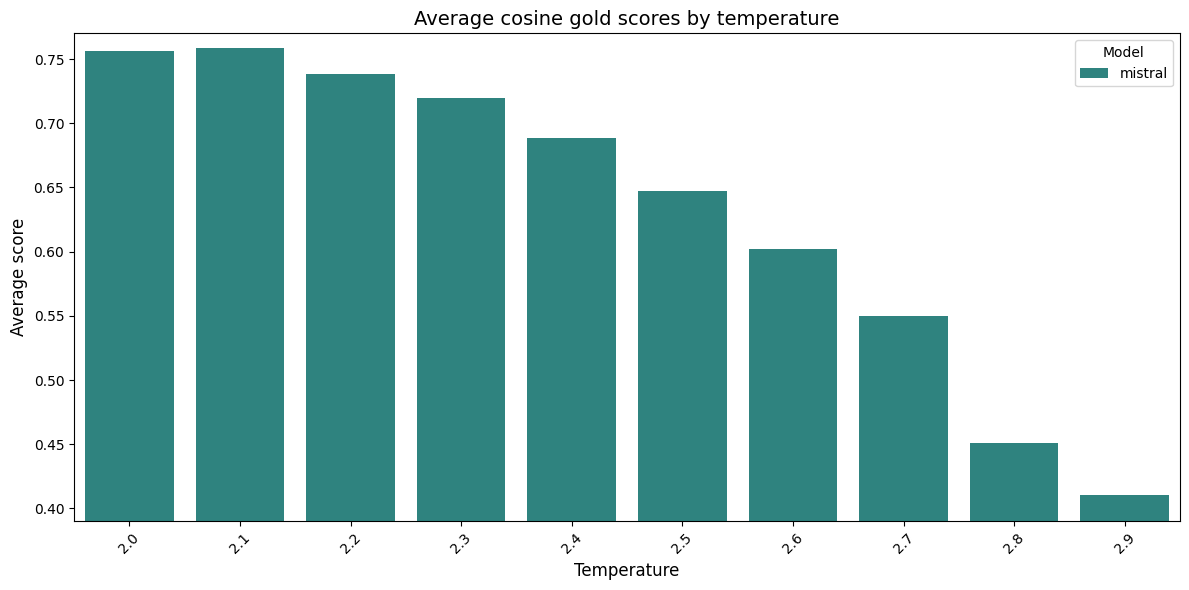

In [11]:
start_index = 0
end_index = 400
print('Sample count', end_index - start_index)
df_mistral = df_mistral[start_index: end_index]
grouped_mistral = df_mistral.groupby('temperature')[['gold_standard_cos']].mean()
grouped_mistral['Model'] = 'mistral'
all_grouped_scores = pd.concat(
    [
        grouped_mistral
    ]
)
all_grouped_scores = all_grouped_scores.reset_index()
melted_scores = all_grouped_scores.melt(
    id_vars=['temperature', 'Model'],
    var_name='Metric',
    value_name='Average'
)
plt.figure(figsize=(12, 6))
sns.barplot(
    x='temperature',
    y='Average',
    hue='Model',
    data=melted_scores,
    palette='viridis'
)
plt.title('Average cosine gold scores by temperature', fontsize=14)
plt.ylabel('Average score', fontsize=12)
plt.ylim(0.39, 0.77)
plt.xlabel('Temperature', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='Model')
plt.tight_layout()
plt.show()

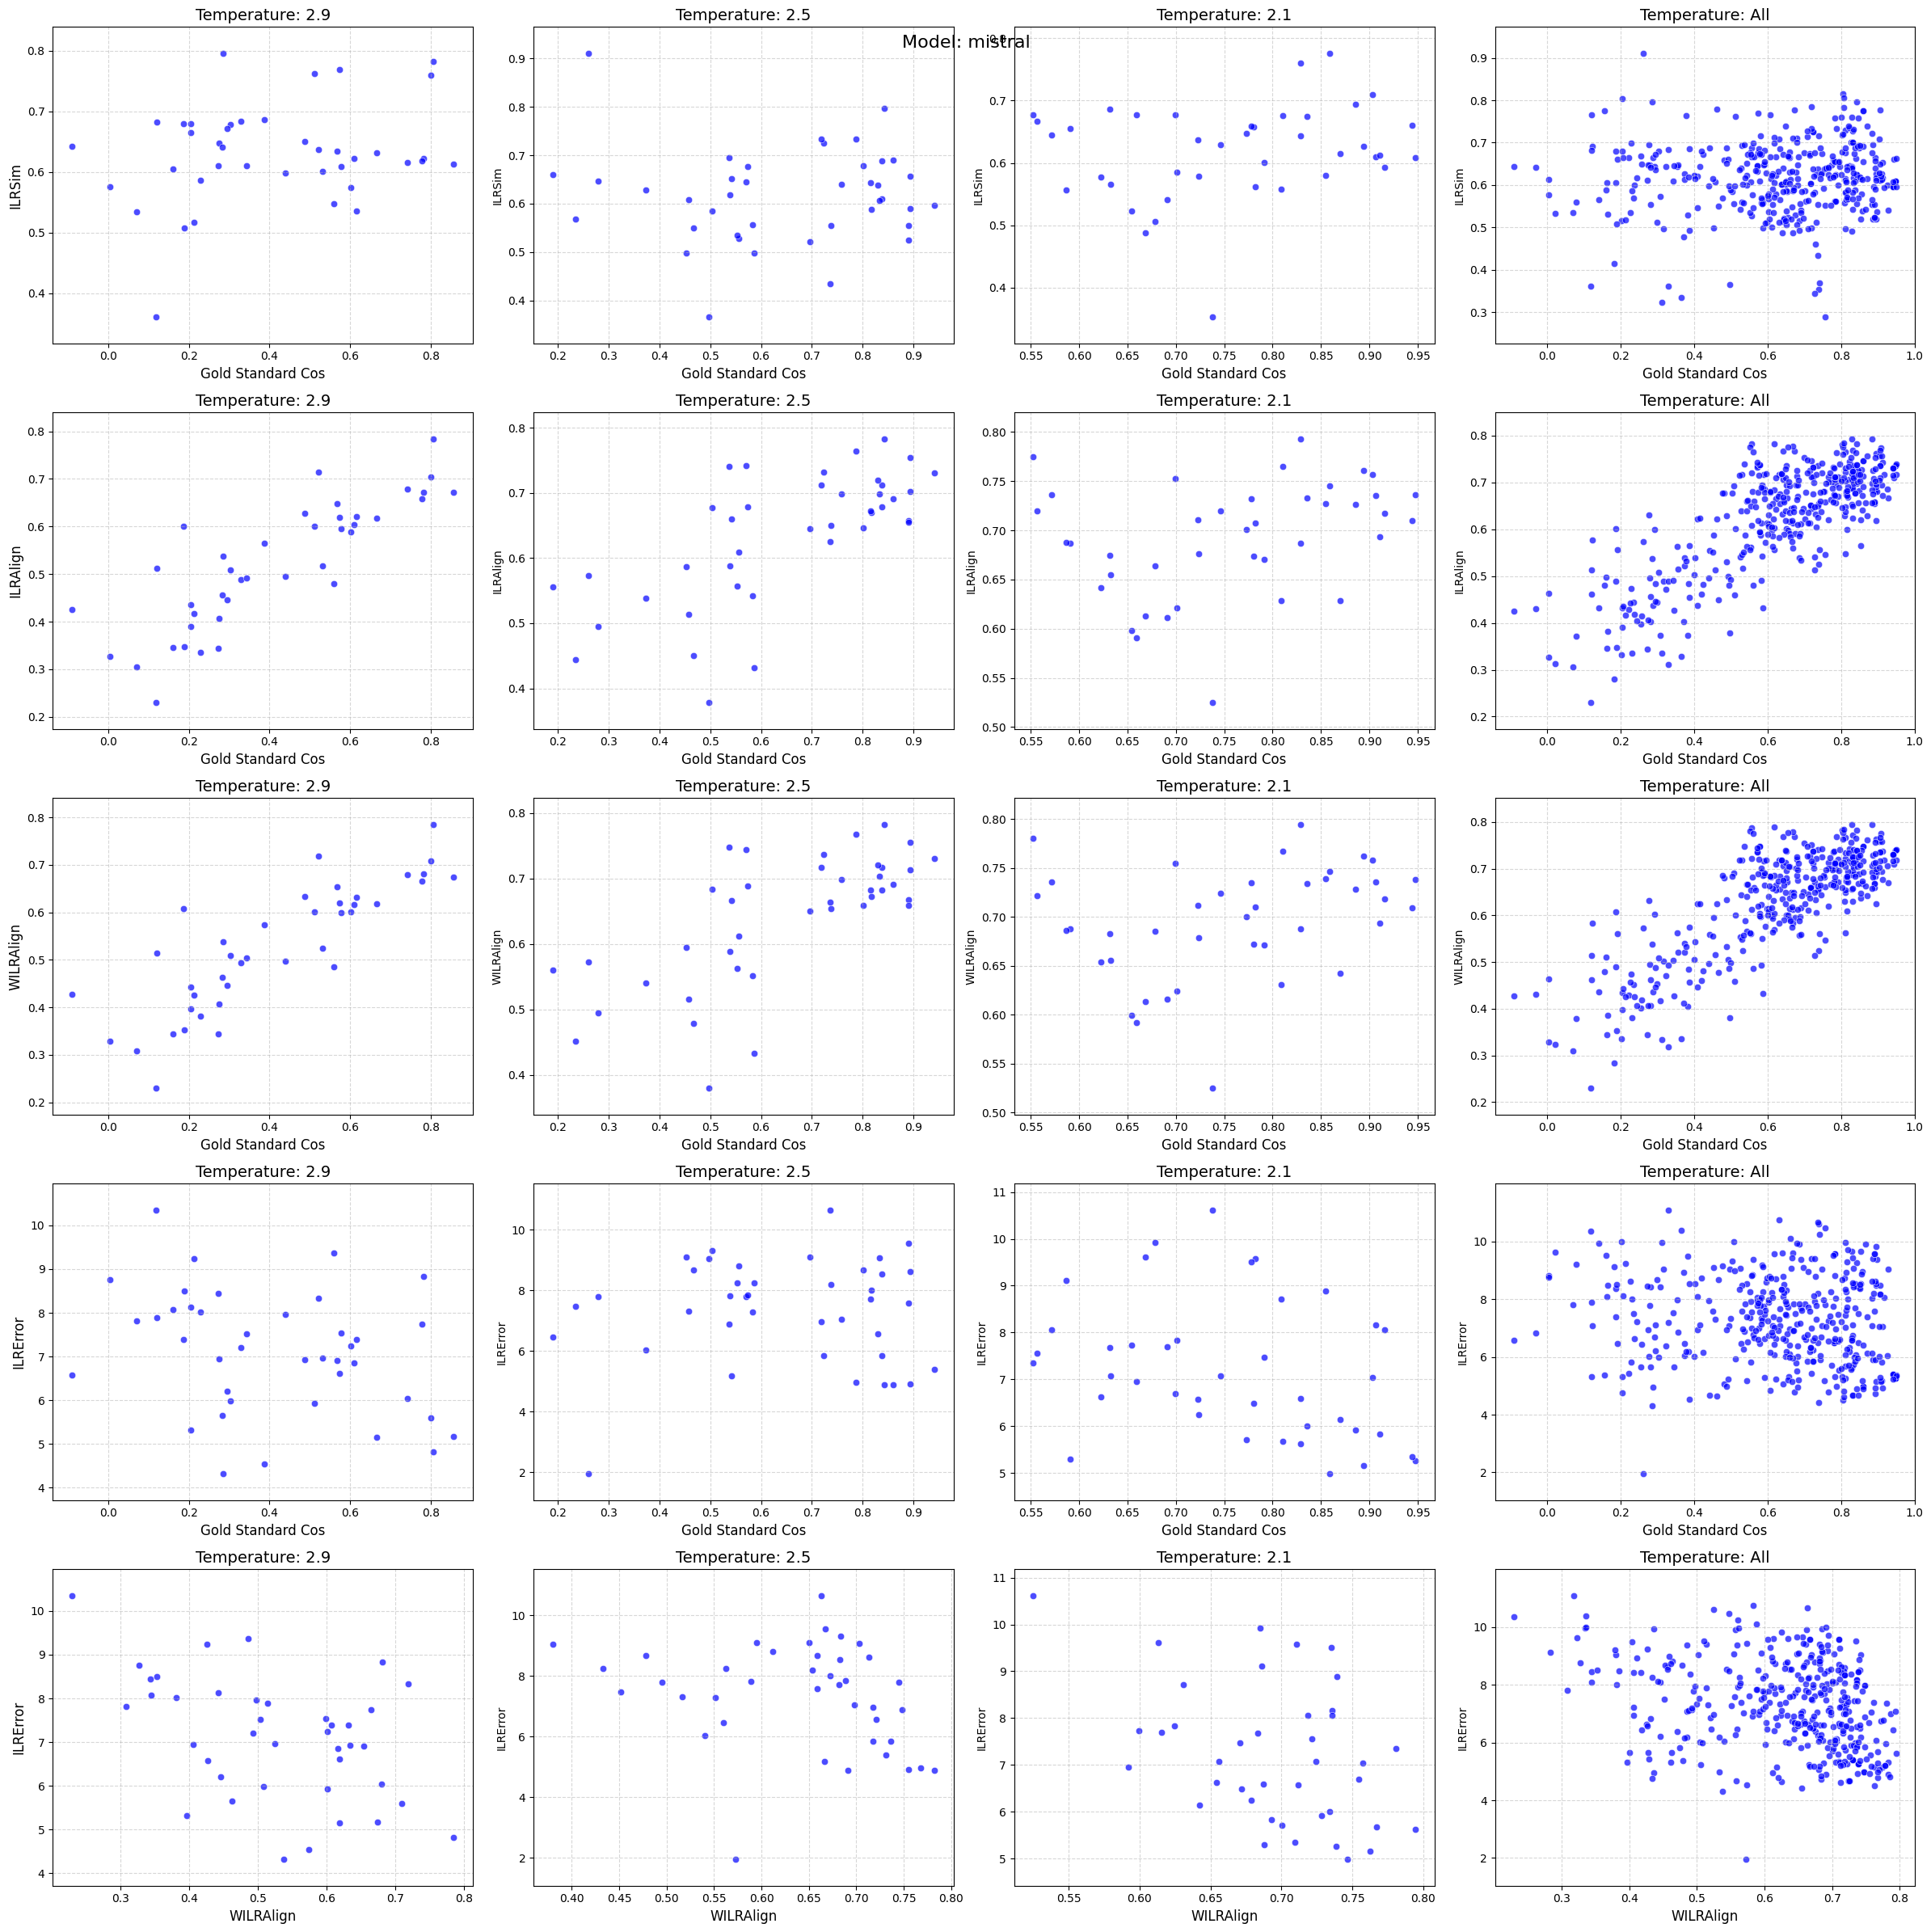

In [12]:
mistral_values = get_key_temperatures(grouped_mistral)
mistral_temperature_selection = [mistral_values[0], mistral_values[1], mistral_values[2]]
temperature_selections = {
    'mistral': (mistral_temperature_selection, df_mistral)
}

max_temps = max(len(temp_selection) for temp_selection, _ in temperature_selections.values()) + 1

for model, (temp_selection, df) in temperature_selections.items():
    fig, axes = plt.subplots(5, max(len(temp_selection) + 1, max_temps),
                              figsize=((max_temps) * 6, 4 * 6),
                              sharey=False)

    def get_dynamic_limits(data, y_column):
        min_val, max_val = data[y_column].min(), data[y_column].max()
        margin = (max_val - min_val) * 0.1
        return min_val - margin, max_val + margin

    for row, y_column, y_label in zip(
        range(6),
        ['ILRSim', 'ILRAlign', 'WILRAlign', 'ILRError', 'ILRError'],
        ['ILRSim', 'ILRAlign', 'WILRAlign', 'ILRError', 'ILRError']
    ):
        for col, temp in enumerate(temp_selection + ['All']):
            ax = axes[row, col] if len(temp_selection) > 1 else axes[row]
            filtered_df = df if temp == 'All' else df[df['temperature'] == temp]
            sns.scatterplot(
                x='gold_standard_cos' if row < 4 else 'WILRAlign',
                y=y_column,
                data=filtered_df,
                ax=ax,
                color='blue',
                alpha=0.7
            )
            y_min, y_max = get_dynamic_limits(filtered_df, y_column)
            ax.set_ylim(y_min, y_max)
            ax.set_title(f'Temperature: {temp}', fontsize=14)
            ax.set_xlabel('Gold Standard Cos' if row < 4 else 'WILRAlign', fontsize=12)
            if col == 0:
                ax.set_ylabel(y_label, fontsize=12)
            ax.grid(True, linestyle='--', alpha=0.5)

    for row in range(4):
        for col in range(len(temp_selection) + 1, max_temps):
            fig.delaxes(axes[row, col] if len(temp_selection) > 1 else axes[row])

    plt.tight_layout()
    plt.suptitle(f'Model: {model}', fontsize=16)
    plt.show()

In [13]:
for model, (temp_selection, df) in temperature_selections.items():
    print(f'Pearson Correlation Coefficients for Model: {model} \n')

    correlation_types = {
        'Gold Standard Cos vs ILRSim': ('gold_standard_cos', 'ILRSim'),
        'Gold Standard Cos vs ILRAlign': ('gold_standard_cos', 'ILRAlign'),
        'Gold Standard Cos vs WILRAlign': ('gold_standard_cos', 'WILRAlign'),
        'Gold Standard Cos vs ILRError': ('gold_standard_cos', 'ILRError')
    }

    for key, (col1, col2) in correlation_types.items():
        print(f'--- {key} ---')
        for temp in temp_selection + ['All']:
            filtered_df = df if temp == 'All' else df[df['temperature'] == temp]
            correlation = filtered_df[col1].corr(filtered_df[col2])
            print(f'Temperature {temp}: {correlation:.4f}')
        print()

Pearson Correlation Coefficients for Model: mistral 

--- Gold Standard Cos vs ILRSim ---
Temperature 2.9: 0.2430
Temperature 2.5: 0.0022
Temperature 2.1: 0.1948
Temperature All: 0.0722

--- Gold Standard Cos vs ILRAlign ---
Temperature 2.9: 0.8408
Temperature 2.5: 0.6857
Temperature 2.1: 0.3048
Temperature All: 0.7925

--- Gold Standard Cos vs WILRAlign ---
Temperature 2.9: 0.8445
Temperature 2.5: 0.6920
Temperature 2.1: 0.2969
Temperature All: 0.8001

--- Gold Standard Cos vs ILRError ---
Temperature 2.9: -0.3148
Temperature 2.5: 0.0431
Temperature 2.1: -0.3328
Temperature All: -0.1149



FALCON AS THE MODEL

Sample count 400


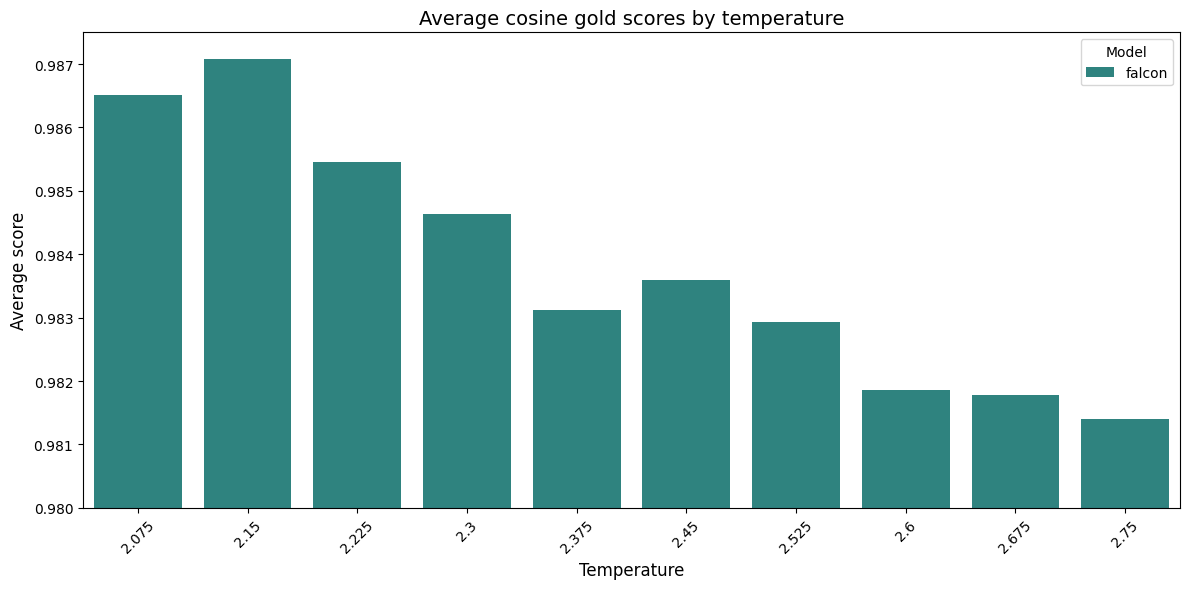

In [14]:
start_index = 0
end_index = 400
print('Sample count', end_index - start_index)
df_falcon = df_falcon[start_index: end_index]
grouped_falcon = df_falcon.groupby('temperature')[['gold_standard_cos']].mean()
grouped_falcon['Model'] = 'falcon'
all_grouped_scores = pd.concat(
    [
        grouped_falcon
    ]
)
all_grouped_scores = all_grouped_scores.reset_index()
melted_scores = all_grouped_scores.melt(
    id_vars=['temperature', 'Model'],
    var_name='Metric',
    value_name='Average'
)
plt.figure(figsize=(12, 6))
sns.barplot(
    x='temperature',
    y='Average',
    hue='Model',
    data=melted_scores,
    palette='viridis'
)
plt.title('Average cosine gold scores by temperature', fontsize=14)
plt.ylabel('Average score', fontsize=12)
plt.ylim(0.9800, 0.9875)
plt.xlabel('Temperature', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='Model')
plt.tight_layout()
plt.show()

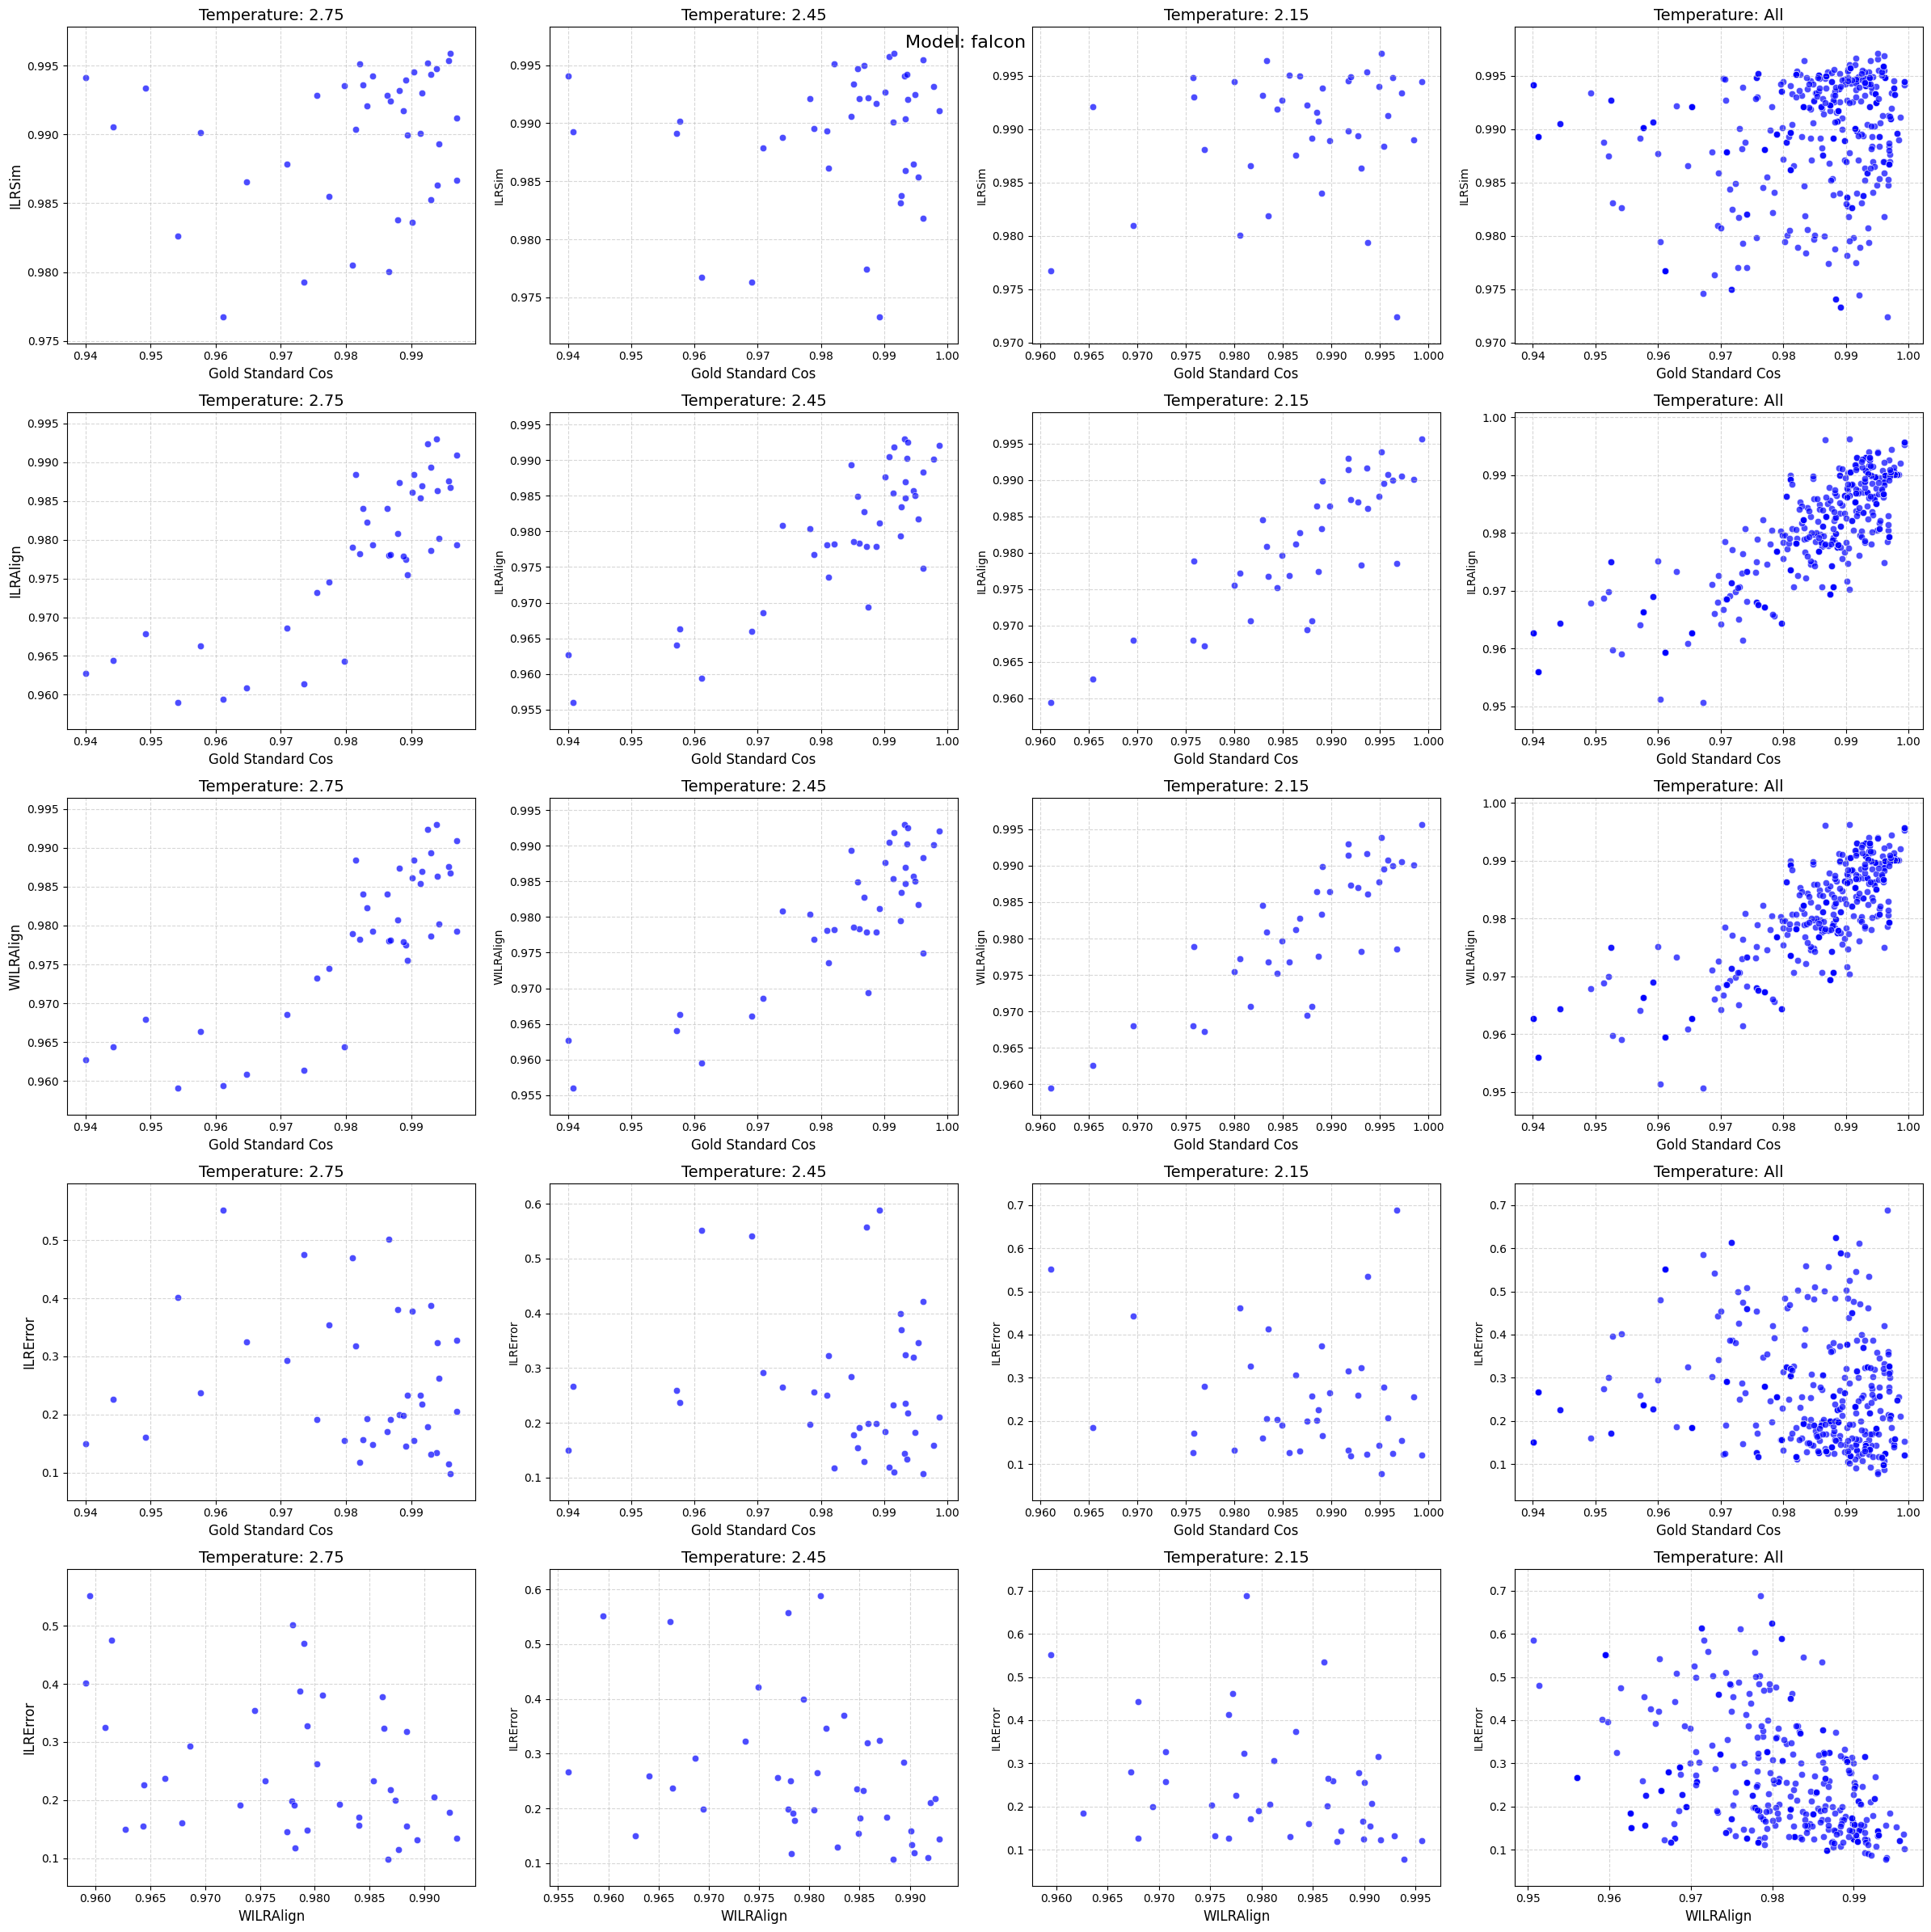

In [15]:
falcon_values = get_key_temperatures(grouped_falcon)
falcon_temperature_selection = [falcon_values[0], falcon_values[1], falcon_values[2]]
temperature_selections = {
    'falcon': (falcon_temperature_selection, df_falcon)
}

max_temps = max(len(temp_selection) for temp_selection, _ in temperature_selections.values()) + 1

for model, (temp_selection, df) in temperature_selections.items():
    fig, axes = plt.subplots(5, max(len(temp_selection) + 1, max_temps),
                              figsize=((max_temps) * 6, 4 * 6),
                              sharey=False)

    def get_dynamic_limits(data, y_column):
        min_val, max_val = data[y_column].min(), data[y_column].max()
        margin = (max_val - min_val) * 0.1
        return min_val - margin, max_val + margin

    for row, y_column, y_label in zip(
        range(6),
        ['ILRSim', 'ILRAlign', 'WILRAlign', 'ILRError', 'ILRError'],
        ['ILRSim', 'ILRAlign', 'WILRAlign', 'ILRError', 'ILRError']
    ):
        for col, temp in enumerate(temp_selection + ['All']):
            ax = axes[row, col] if len(temp_selection) > 1 else axes[row]
            filtered_df = df if temp == 'All' else df[df['temperature'] == temp]
            sns.scatterplot(
                x='gold_standard_cos' if row < 4 else 'WILRAlign',
                y=y_column,
                data=filtered_df,
                ax=ax,
                color='blue',
                alpha=0.7
            )
            y_min, y_max = get_dynamic_limits(filtered_df, y_column)
            ax.set_ylim(y_min, y_max)
            ax.set_title(f'Temperature: {temp}', fontsize=14)
            ax.set_xlabel('Gold Standard Cos' if row < 4 else 'WILRAlign', fontsize=12)
            if col == 0:
                ax.set_ylabel(y_label, fontsize=12)
            ax.grid(True, linestyle='--', alpha=0.5)

    for row in range(4):
        for col in range(len(temp_selection) + 1, max_temps):
            fig.delaxes(axes[row, col] if len(temp_selection) > 1 else axes[row])

    plt.tight_layout()
    plt.suptitle(f'Model: {model}', fontsize=16)
    plt.show()

In [16]:
for model, (temp_selection, df) in temperature_selections.items():
    print(f'Pearson Correlation Coefficients for Model: {model} \n')

    correlation_types = {
        'Gold Standard Cos vs ILRSim': ('gold_standard_cos', 'ILRSim'),
        'Gold Standard Cos vs ILRAlign': ('gold_standard_cos', 'ILRAlign'),
        'Gold Standard Cos vs WILRAlign': ('gold_standard_cos', 'WILRAlign'),
        'Gold Standard Cos vs ILRError': ('gold_standard_cos', 'ILRError')
    }

    for key, (col1, col2) in correlation_types.items():
        print(f'--- {key} ---')
        for temp in temp_selection + ['All']:
            filtered_df = df if temp == 'All' else df[df['temperature'] == temp]
            correlation = filtered_df[col1].corr(filtered_df[col2])
            print(f'Temperature {temp}: {correlation:.4f}')
        print()

Pearson Correlation Coefficients for Model: falcon 

--- Gold Standard Cos vs ILRSim ---
Temperature 2.75: 0.1870
Temperature 2.45: 0.1030
Temperature 2.15: 0.2162
Temperature All: 0.1820

--- Gold Standard Cos vs ILRAlign ---
Temperature 2.75: 0.8177
Temperature 2.45: 0.8464
Temperature 2.15: 0.8418
Temperature All: 0.8088

--- Gold Standard Cos vs WILRAlign ---
Temperature 2.75: 0.8179
Temperature 2.45: 0.8469
Temperature 2.15: 0.8419
Temperature All: 0.8089

--- Gold Standard Cos vs ILRError ---
Temperature 2.75: -0.1607
Temperature 2.45: -0.1162
Temperature 2.15: -0.2000
Temperature All: -0.1720



SUMMARY

/tmp/ipython-input-2005726909.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
/tmp/ipython-input-2005726909.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
/tmp/ipython-input-2005726909.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
/tmp/ipython-input-2005726909.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


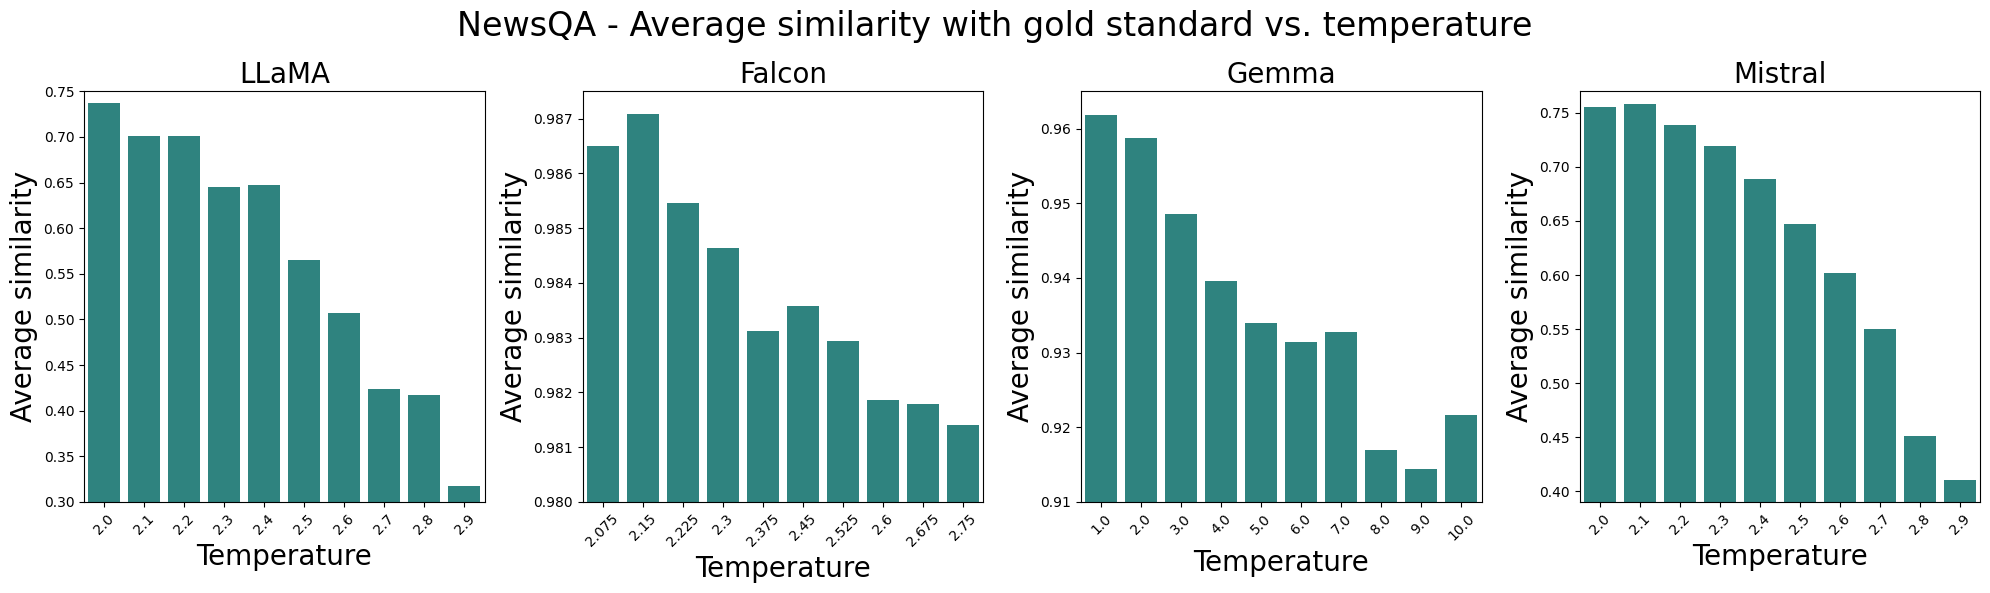

In [17]:
def plot_model_scores(df, model_name, ax, y1, y2):
    grouped_df = df.groupby('temperature')[['gold_standard_cos']].mean()
    grouped_df['Model'] = model_name
    grouped_df = grouped_df.reset_index()
    melted_scores = grouped_df.melt(
        id_vars=['temperature', 'Model'],
        var_name='Metric',
        value_name='Average'
    )

    sns.barplot(
        x='temperature',
        y='Average',
        hue='Model',
        data=melted_scores,
        palette='viridis',
        ax=ax
    )
    ax.set_title(f'{model_name}', fontsize=20)
    ax.legend_.remove()
    ax.set_ylabel('Average similarity', fontsize=20)
    ax.set_ylim(y1, y2)
    ax.set_xlabel('Temperature', fontsize=20)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

fig, axes = plt.subplots(1, 4, figsize=(20, 6))


plot_model_scores(df_llama, 'LLaMA', axes[0], 0.3, 0.75)
plot_model_scores(df_falcon, 'Falcon', axes[1], 0.9800, 0.9875)
plot_model_scores(df_gemma, 'Gemma', axes[2], 0.91, 0.965)
plot_model_scores(df_mistral, 'Mistral', axes[3], 0.39, 0.77)

fig.suptitle('NewsQA - Average similarity with gold standard vs. temperature', fontsize=24)
plt.tight_layout()
plt.show()

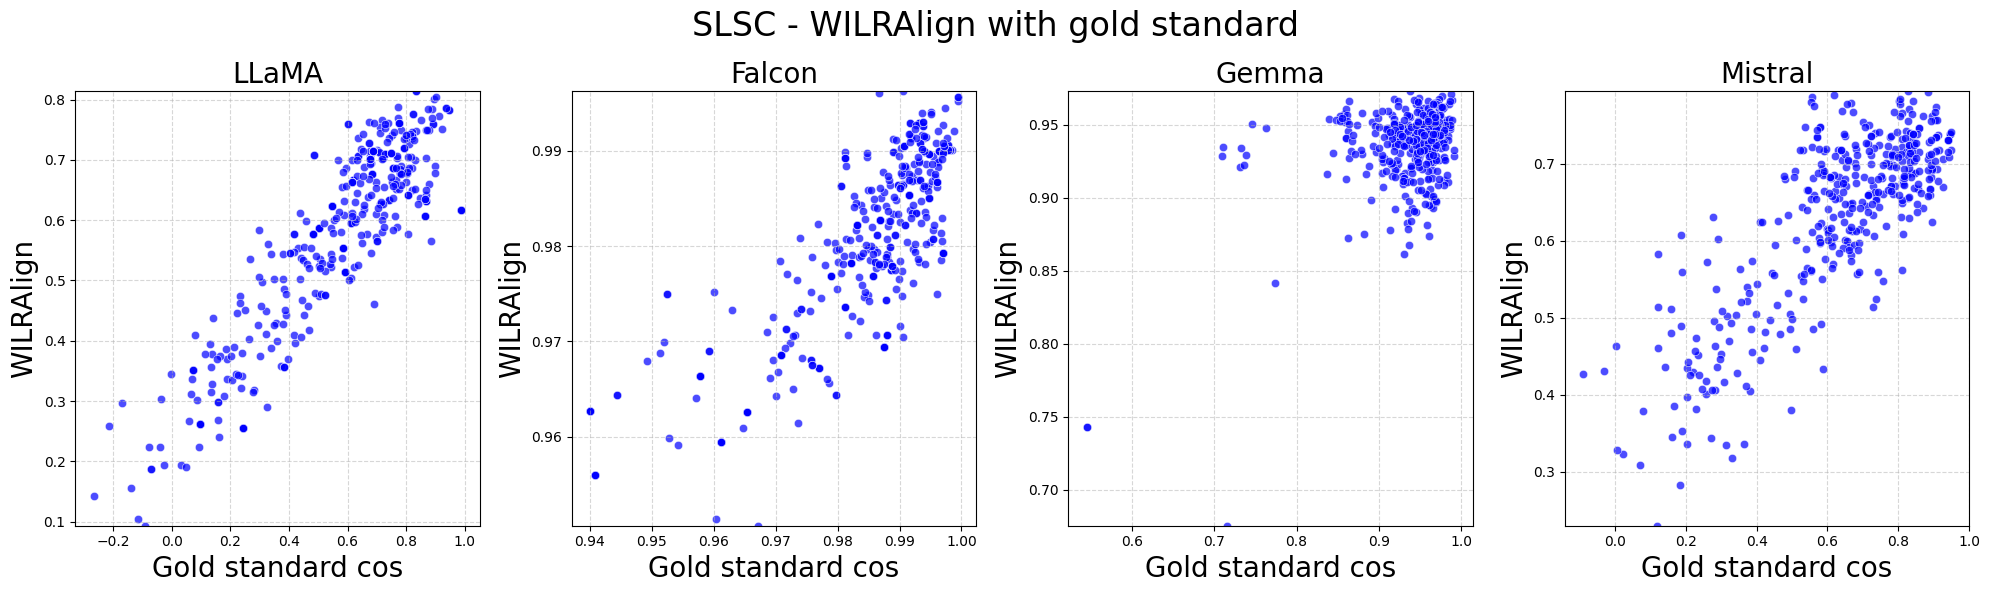

In [18]:
def plot_model_wilrAlign_corr(df, model_name, ax):
    sns.scatterplot(
        x='gold_standard_cos',
        y='WILRAlign',
        data=df,
        ax=ax,
        color='blue',
        alpha=0.7
    )

    ax.set_ylim(df['WILRAlign'].min(), df['WILRAlign'].max())
    ax.set_title(f'{model_name}', fontsize=20)
    ax.set_xlabel('Gold standard cos', fontsize=20)
    ax.set_ylabel('WILRAlign', fontsize=20)
    ax.grid(True, linestyle='--', alpha=0.5)

fig, axes = plt.subplots(1, 4, figsize=(20, 6))
plot_model_wilrAlign_corr(df_llama, 'LLaMA', axes[0])
plot_model_wilrAlign_corr(df_falcon, 'Falcon', axes[1])
plot_model_wilrAlign_corr(df_gemma, 'Gemma', axes[2])
plot_model_wilrAlign_corr(df_mistral, 'Mistral', axes[3])
fig.suptitle('SLSC - WILRAlign with gold standard', fontsize=24)
plt.tight_layout()
plt.show()

In [19]:
rename_dict = {
    'judge_answer_answerGenerated_llama_cos': 'ans_llama',
    'judge_answer_answerGenerated_falcon_cos': 'ans_falcon',
    'judge_answer_answerGenerated_gemma_cos': 'ans_gemma',
    'judge_answer_answerGenerated_mistral_cos': 'ans_mistral',
    'question_answerGenerated_llama_cos': 'ques_llama',
    'question_answerGenerated_falcon_cos': 'ques_falcon',
    'question_answerGenerated_gemma_cos': 'ques_gemma',
    'question_answerGenerated_mistral_cos': 'ques_mistral'
}

df_llama = df_llama.rename(columns=rename_dict)
df_falcon = df_falcon.rename(columns=rename_dict)
df_gemma = df_gemma.rename(columns=rename_dict)
df_mistral = df_mistral.rename(columns=rename_dict)

dfs = {'Llama': df_llama, 'Falcon': df_falcon, 'Gemma': df_gemma, 'Mistral': df_mistral}
correlation_raw_columns = list(rename_dict.values())
gold_standard_col = 'gold_standard_cos'
correlation_raw_df = pd.DataFrame(index=dfs.keys(), columns=correlation_raw_columns)
for df_name, df in dfs.items():
    for col in correlation_raw_columns:
        if col in df.columns and gold_standard_col in df.columns:
            correlation_raw_df.loc[df_name, col] = round(df[col].corr(df[gold_standard_col]), 4)


correlation_raw_df = correlation_raw_df.astype(float)
correlation_raw_df

,ans_llama,ans_falcon,ans_gemma,ans_mistral,ques_llama,ques_falcon,ques_gemma,ques_mistral
Llama,NaN,-0.0401,-0.0668,-0.1170,NaN,0.1547,0.2663,0.3114
Falcon,-0.1691,NaN,-0.1676,-0.2579,0.1915,NaN,-0.0565,0.2416
Gemma,0.6639,0.6123,NaN,0.6922,-0.0698,0.0370,NaN,-0.0439
Mistral,0.0494,0.2219,-0.0839,NaN,0.0526,0.0104,0.1123,NaN


In [20]:
temperature_selections = {
    'LLaMA': df_llama,
    'Gemma': df_gemma,
    'Falcon': df_falcon,
    'Mistral': df_mistral
}
correlation_types = {
    'Answer Sim Mean': ('gold_standard_cos', 'answer_judge_cos_mean'),
    'BM25 Mean': ('gold_standard_cos', 'question_bm25_score_mean'),
    'ROUGE Mean': ('gold_standard_cos', 'question_rouge_score_mean'),
    'BLEU Mean': ('gold_standard_cos', 'question_bleu_score_mean'),
    'ILRSim': ('gold_standard_cos', 'ILRSim'),
    'ILRError': ('gold_standard_cos', 'ILRError'),
    'ILRAlign': ('gold_standard_cos', 'ILRAlign'),
    'WILRAlign': ('gold_standard_cos', 'WILRAlign')
}
results = []

for model, df in temperature_selections.items():
    row = {'Model': model}
    for key, (col1, col2) in correlation_types.items():
        correlation = df[col1].corr(df[col2])
        row[key] = round(correlation, 4)
    results.append(row)
table_df = pd.DataFrame(results)
average_row = {'Model': 'Average'}
for key in correlation_types.keys():
    average_correlation = table_df[key].mean()
    average_row[key] = round(average_correlation, 4)

table_df = pd.concat([table_df, pd.DataFrame([average_row])], ignore_index=True)
table_df

,Model,Answer Sim Mean,BM25 Mean,ROUGE Mean,BLEU Mean,ILRSim,ILRError,ILRAlign,WILRAlign
0,LLaMA,-0.0953,0.0496,0.2346,0.1351,0.3022,-0.2748,0.8953,0.8980
1,Gemma,0.6789,-0.0732,0.0715,-0.0291,-0.0290,-0.0918,0.4308,0.4310
2,Falcon,-0.2755,0.1768,0.0574,0.0431,0.1820,-0.1720,0.8088,0.8089
3,Mistral,0.0836,-0.1502,0.0866,-0.0028,0.0722,-0.1149,0.7925,0.8001
4,Average,0.0979,0.0008,0.1125,0.0366,0.1318,-0.1634,0.7318,0.7345
